<a href="https://colab.research.google.com/github/daleas0120/Example_notebooks/blob/main/Network_Pruning_Example.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Network Pruning Example

Ashley S. Dale

## Introduction

Model pruning is an effective way to reduce model size and complexity.  It is a heuristic approach that removes nodes from a network by considering a weight threshold in the context of model performance.  In the notebook below, a simple multi-layer perceptron is used to classify two of the three classes from the *Iris* dataset.  Results show that for the data and network structure given, it is possible to eliminate many of the connections.

In [ ]:
# Python Imports
from sklearn.datasets import load_iris
from sklearn.neural_network import MLPClassifier
import numpy as np
from sklearn.metrics import average_precision_score as map
import matplotlib.pyplot as plt
import networkx as nx

## Dataset
The scikit-learn implementation of the ```iris``` dataset is loaded.  By default, the Iris dataset consists of three classes (Setosa, Versicolour, and Virginica) with fifty examples each, and four features (Sepal Length, Sepal Width, Petal Length and Petal Width).  Two of the classes (Setosa, Versicolour) were selected; 70% was assigned to a train dataset partition, and 30% was assigned to a test dataset partition.

In [ ]:
# Load the dataset
irises = load_iris()
data = irises['data']
targets = irises['target']

# Get the data and labels
X = data[targets != 2]
y = targets[targets != 2]

# Randomly partition the data into train and test
rand_mask = np.random.uniform(0, 1, len(X)) > 0.3

# Applying the partition mask
X_train = X[rand_mask == True]
X_test = X[rand_mask == False]

y_train = y[rand_mask == True]
y_test = y[rand_mask == False]

In the figure below, the four features are plotted against eachother and labeled by class.  The data appears to be linearly seperable, which suggests that the multi-layer perceptron model will be able to classify the data successfully.

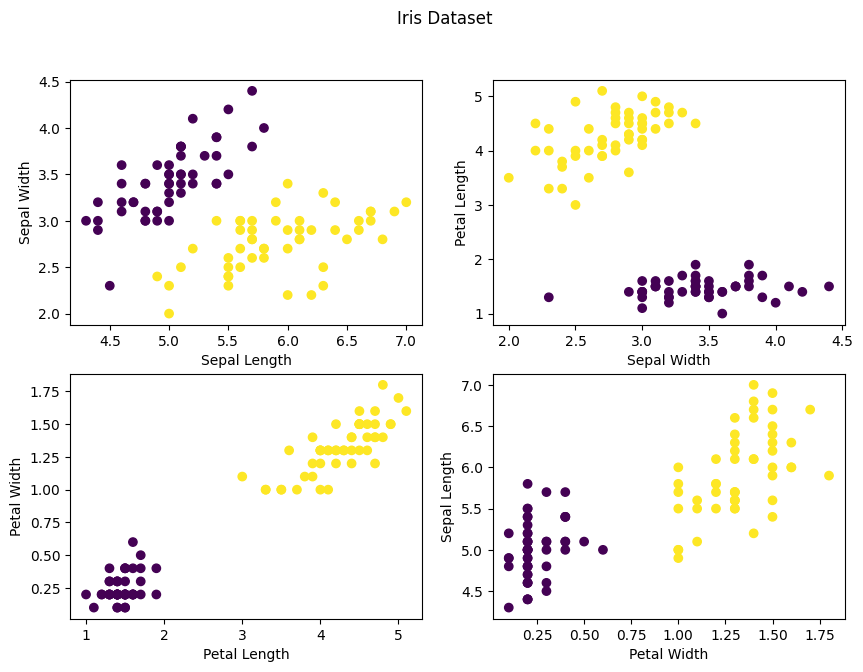

In [ ]:
fig, ax = plt.subplots(2, 2, figsize=(10, 7))
ax[0, 0].scatter(X[:, 0], X[:, 1], c = y)
ax[0,0].set_xlabel('Sepal Length')
ax[0,0].set_ylabel('Sepal Width')

ax[0, 1].scatter(X[:, 1], X[:, 2], c = y)
ax[0,1].set_xlabel('Sepal Width')
ax[0,1].set_ylabel('Petal Length')

ax[1, 0].scatter(X[:, 2], X[:, 3], c = y)
ax[1,0].set_xlabel('Petal Length')
ax[1,0].set_ylabel('Petal Width')

ax[1, 1].scatter(X[:, 3], X[:, 0], c = y)
ax[1,1].set_xlabel('Petal Width')
ax[1,1].set_ylabel('Sepal Length')

fig.suptitle('Iris Dataset')
plt.show()

## Model

A fully connected network with two hidden layers of size 5 and 3 was randomly initialized.  The network is visualized as shown below.  The four input nodes {1, 2, 3, 4} accept the four input features.  The two output nodes {13, 14} function as the binary classifier.  Each node uses a relu activation function.

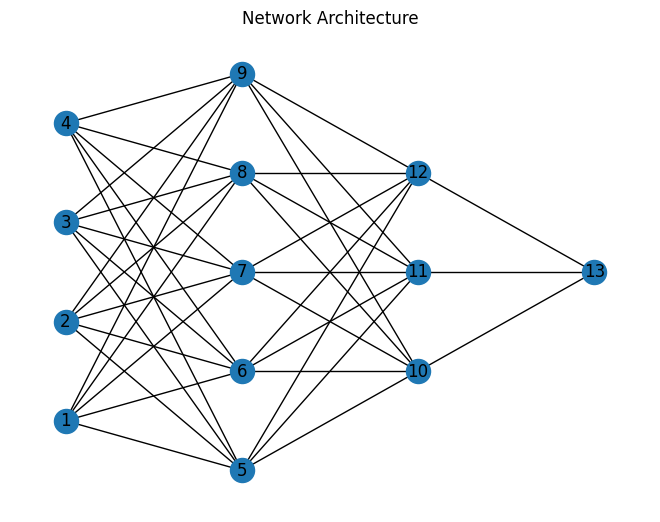

In [ ]:
G = nx.Graph()

positions = {1:[0,1], 2:[0,3], 3:[0,5], 4:[0,7],
             5:[2,0], 6:[2,2], 7:[2,4], 8:[2,6], 9:[2,8],
             10:[4,2], 11:[4,4], 12:[4,6],
             13:[6,4]}

edges = [(1, 5), (1,6), (1,7), (1,8), (1,9),
                  (2,5),(2,6),(2,7),(2,8),(2,9),
                  (3,5),(3,6),(3,7),(3,8),(3,9),
                  (4,5),(4,6),(4,7),(4,8),(4,9),
                  (5,10),(5,11),(5,12),(6,10),(6,11),(6,12),
                  (7,10),(7,11),(7,12),(8,10),(8,11),(8,12),
                  (9,10),(9,11),(9,12),
                  (10,13),(11,13),(12,13)]

G.add_nodes_from(positions)

G.add_edges_from(edges)

nx.draw(G, pos=positions,with_labels=True)
plt.gcf()
plt.title("Network Architecture")
plt.show()

The model is then trained for 1000 steps using stochastic gradient descent, L2 regularization using an alpha value of 0.1, and a cross entropy loss.  The figure below shows the model architecture with connections between perceptrons visualized according to their relative weight.

In [ ]:
n_epochs = 1000 #Number of epochs to train model

# Initializing the classifier object
clf = MLPClassifier(solver='sgd', alpha=1e-1, hidden_layer_sizes=(5, 3),
                    max_iter=n_epochs,n_iter_no_change=n_epochs)

# Training the model
clf.fit(X_train, y_train)

/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


MLPClassifier(alpha=0.1, hidden_layer_sizes=(5, 3), max_iter=1000,
              n_iter_no_change=1000, solver='sgd')

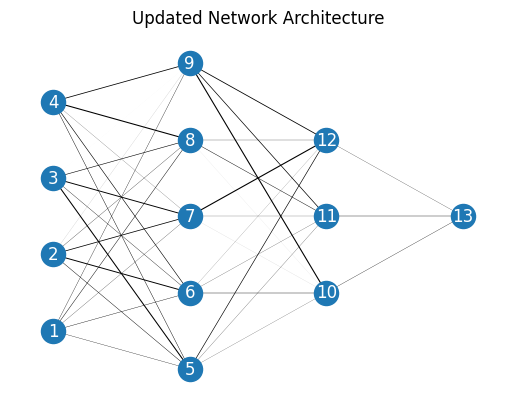

In [ ]:
# Update the Graph object used in the plot above with the weights and biases for
#later visualization.

edge_weights = list(np.reshape(clf.coefs_[0], (20)))
edge_weights.extend(np.reshape(clf.coefs_[1], (15)))

nx.set_edge_attributes(G, values=edge_weights, name='weight')

widths = nx.get_edge_attributes(G, 'weight')
nodelist = G.nodes()

nx.draw_networkx_nodes(G,positions,
                       nodelist=nodelist)

nx.draw_networkx_edges(G,positions,
                       edgelist=edges,
                       width=edge_weights*100)

nx.draw_networkx_labels(G, pos=positions,
                        labels=dict(zip(nodelist,nodelist)),
                        font_color='white')

plt.gcf()
plt.box(False)
plt.title('Updated Network Architecture')
plt.show()

The training loss is plotted as a function of the number of steps below.  From this plot, the model appears overtrained.  However, for this implementation overtraining is not a concern as the purpose is to determine how many weights can be removed while maintaining model performance.

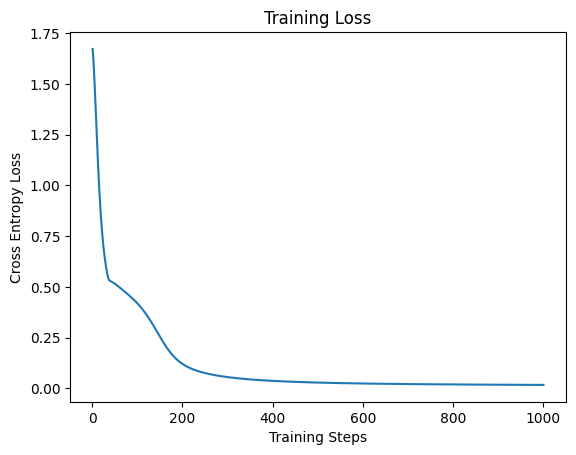

In [ ]:
# Plotting the training loss
fig, ax = plt.subplots(1,1)
steps = len(clf.loss_curve_)
ax.plot(np.linspace(1, steps, steps), clf.loss_curve_)
ax.set_xlabel('Training Steps')
ax.set_ylabel('Cross Entropy Loss')
ax.set_title('Training Loss')
plt.show()

Predictions are made on the test set, and an initial mean average precision is calculated.  The range of the mean average precision is [0,1], with a value of 1 equivalent to perfect precision.

In [ ]:
# Predicting labels for the test set
y_pred = clf.predict(X_test)

pred_map = map(y_test, y_pred)

print(f"Mean Average Precision: {pred_map}")

Mean Average Precision: 1.0


## Weight Thresholding Implementation

Now we implement the heuristic approach of weight removal to identify which nodes to remove.  Below, a function is defined that sweeps through various threshold values, and determines how the model performs on the test data for that threshold.  For each threshold value, any weight with an absolute value equal to or less than the threshold is removed from the network.

In [ ]:
def thresholding_routine(wt_thresholds):
    '''
    Applies thresholds to model and gets prediction error

    wt_thresholds: list of thresholds
    returns: list of errors, list of how many nodes removed for each threshold
    '''

    err = [] # variable for error values
    num_zeros = [] # variable to hold num nodes set to zero

    for threshold in wt_thresholds:
        #Set all weights less than threshold equal to zero
        clf.coefs_[0][np.abs(clf.coefs_[0])<threshold] = 0
        clf.coefs_[1][np.abs(clf.coefs_[1])<threshold] = 0

        # Count how many weights are now zero
        num_zeros.append(
            np.count_nonzero(clf.coefs_[0]==0)+
            np.count_nonzero(clf.coefs_[1]==0))

        # Get preditions on the test set
        y_pred = clf.predict(X_test)

        # Calculate the mean average precision and save for later
        err.append(map(y_test, y_pred))

    return err, num_zeros

The maximum threshold value is the largest weight value in the network.  A linear interpretation of 1000 different thresholds between 0 and the max weight value is considered. The exact number of weights that can be removed without sacrificing performance depends upon training outcomes and the network's initial state.  However, typical values achieved range between 40-60% of the network's weights.

In [ ]:
# Determine where to stop thresholding
threshold_max = np.max([np.max(clf.coefs_[0]), np.max(clf.coefs_[1])])

# Create a range of 1000 thresholds to test
thresholds = np.linspace(0, threshold_max, 1000)

In [ ]:
# Run function defined above
err_vals, zeros = thresholding_routine(thresholds)

In [ ]:
# Determine the weight threshold cutoff

threshold_mask = np.array(err_vals) > 0.9
max_wt = thresholds[len(thresholds[threshold_mask == True])]
print(f"The maximum weight threshold is {max_wt}")

# Determine the maximum number of weights removed
max_zeros_removed = zeros[len(thresholds[threshold_mask == True])]
print(f"The maximum number of weights removed is {max_zeros_removed}")

The maximum weight threshold is 0.6303783306038981
The maximum number of weights removed is 22


The results are plotted below.  The figure on the left shows how the average precision of the classification results change based on the magnitude of the weights remaining.  The figure on the right shows how many weights are removed at each threshold.

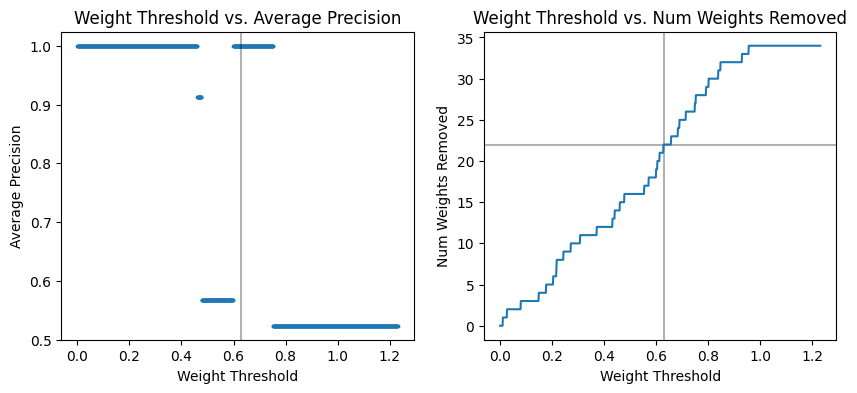

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(10,4))
ax[0].axvline(x = max_wt, color = 'k', alpha=0.3)
ax[0].scatter(thresholds, err_vals, s=3)

ax[0].set_title('Weight Threshold vs. Average Precision')
ax[0].set_xlabel('Weight Threshold')
ax[0].set_ylabel('Average Precision')

ax[1].axvline(x = max_wt, color = 'k', alpha=0.3)
ax[1].axhline(y = max_zeros_removed, color = 'k', alpha=0.3)
ax[1].plot(thresholds, zeros)
ax[1].set_title('Weight Threshold vs. Num Weights Removed')
ax[1].set_xlabel('Weight Threshold')
ax[1].set_ylabel('Num Weights Removed')
plt.show()

## Summary

Network pruning is an effective way to maintain network accuracy while reducing network size, complexity, and evaluation time.  As shown above, for a simple multi-layer perceptron with two hidden layers, as much as 40-60% of the network weights can be safely removed without negatively affecting network performance.  However, this value is dependent on the network's initialization, which reflects the heuristic nature of this method.